Jupyter-блокнот основного решения соревнования `Happy Data Year` от Росбанка (платформа [Boosters.pro]).
Решение заняло 48 место на Public LeaderBoard и 21 место на приватной доске.

[Boosters.pro]:https://boosters.pro/champ_21

**Автор:** Липко Иван

**E-mail:** ivanlipko@yandex.ru

**Для работы нам понадобятся библиотеки:**

sudo ./conda install -c conda-forge lightgbm 

sudo ./anaconda3/bin/conda install -c conda-forge/label/gcc7 selenium



# Общий ход решения
(протяжении соревнования)

1. [Поиск недостающих адресов].
   
   Делается **Допущение 1 - Поле `address_rus` соответствует `address`**
   
   а) делаем транслитерацию поля `address` для тех банкоматов, где нет координат и `address_rus`.
   
   б) Парсим данные с Яндекс.Карт основываясь на `address_rus`: описание места, координаты, расстояние до ближайшей остановки (станция или метро, что первое даст), количество остановок рядом, категории предприятий, которые находятся в этом же здании.
    Структура данных для одного банкомата:
       dict
           index
           id
           описание1 (обычно адрес или название)
           описание2 (обычно город, страна, почтовый индекс)
           координаты
               lat
               long
           количество остановок рядом
           расстояние до ближайшей остановки
           список категорий
   
   Результат храним в файле `info_index.json.txt` (где *index* - число, индекс банкомата в датафрейме) в папке `./data/all_atms_info/*` . Сейчас всё это лежит в архиве `address_rus.7z`.
   
   Если где-то что-то не собирается - добираем, модифицируя транслитератор и делая парсинг на основе полей `address`, `address_translit`


2. [Добавляем спарсенную информацию] в датафрейм, генерируем новые признаки:
    *  Количество остановок рядом 
    *  расстояние до ближайшей остановки
    *  Количество банкоматов стоящих по одному адресу
    *  Расстояния до ближайших банкоматов
            distance_%i
            indexes_%i
            var_%i
            mean
            median
    *  Город размещения и LabelEncode для городов размещения
    *  Метка "Редкие города"
    *  Количество банкоматов в городе
    *  Категории зданий (предприятий), в которых находятся банкоматы
    *  Количество банкоматов в одной точке, определённое по координатам, а не адресу

3. [Визуальный анализ данных]

    * [Распределение банкоматов по банкам] 
    * [В каких местах размещены банкоматы?] 
    * [Распределение target в зависимости от банка] 
    * [Распределение target в зависимости от города] 
    * [Распределение target в зависимости от категорий зданий] 
    * [Распределение target в зависимости от количества банкоматов в одном месте?] 
    * [Расстояния до остановок в больших и малых городах?] 
    * [Матрица корреляций - мало что скажет] 

4. Выясняется, что **Допущение 1** ложное. [Предпринимаю попытку чистки выбросов]. Для этого делаю обогащение поля `address` (приведение названий городов ко одному виду, убирание шилшних символов и прочее), а результат кладу в `address_translit`. Делать это для всех адресов уже не удаётся (1 сутки до конца). Поэтому предпринимается попытка посмотреть распределение положения банкоматов по городам и всё что значительно далеко от общей массы - парсить по полю `address_translit`. Яндекс.Карты это очень хорошо делают.

5. Почищенные (но не все) таким образом данные дают хороший прирост на **leaderBoard** и в итоге на **привате**.
    Для обучения в основном [использовался **lightgbm**]. В противовес ему использовались другие регрессоры, не давшие лучше результат на **leaderBoard**:
    * Decision Tree => Adaboost, Bagging
    * GradientBoosting
    * RandomForest, RandomForest для банкоматов Росбанка и других (не хватило времени допилить)
    * SVRegression
    * BayesianRidge
    
    Результат их применения можно посмотреть в `Другие регрессоры.ipynb`.
    
В файле `Полезные заметки.ipynb` можно посмотреть различные заметки, которые возникли у меня и других участников во время соревнования, что стоит сделать после соревнований.
    
    
[Поиск недостающих адресов]: #Поиск-недостающих-адресов
[Добавляем спарсенную информацию]: #Ввод-данных-в-датафрейм
[Визуальный анализ данных]: #Изучаю-Данные

[Предпринимаю попытку чистки выбросов]: #Попытка-чистить-данные,-убирая-выбросы
[использовался **lightgbm**]: #Алгоритм-Оценки


[Распределение банкоматов по банкам]:#Распределение-банкоматов-по-банкам
[В каких местах размещены банкоматы?]:#В-каких-местах-размещены-банкоматы?
[Распределение target в зависимости от банка]:#Распределение-target-в-зависимости-от-банка
[Распределение target в зависимости от города]:#Распределение-target-в-зависимости-от-города
[Распределение target в зависимости от категорий зданий]:#Распределение-target-в-зависимости-от-категорий-зданий
[Распределение target в зависимости от количества банкоматов в одном месте?]:	#Распределение-target-в-зависимости-от-количества-банкоматов-в-одном-месте?
[Расстояния до остановок в больших и малых городах?]:#Расстояния-до-остановок-в-больших-и-малых-городах?
[Матрица корреляций - мало что скажет]:#Матрица-корреляций---мало-что-скажет


## Инструменты сбора признаков

### Парсинг
Сбор данных производится с сайта [Яндекс.Карты]. Поисковый результат обычно содержит описание точки, координаты, что находится в этом здании, адреса и прочее. Загрузка страниц производится через **selenium**. Далее парсится страница. Это делается с помощью модуля `myutils.py` и кода обработки результатов внутри jupyter-блокнота. 

[Яндекс.Карты]:https://yandex.ru/maps/

Модуль `myutils.py` одержит функции:

```python
def get_near_info_strict(dr, address, fp)
#     Осуществляет загрузку страницы
#     dr - selenium chromedriver
#     address - адресс поиска (часть поискового запроса)
#     fp - handle -файла для записи в лог
#     Возвращает dict с описанием

def find_onpage(dr, fp)
#     Ищет инфу на странице
#     dr - selenium chromedriver
#     fp - handle -файла для записи в лог
#     Возвращает dict с описанием

def upgrade_cities(X, cities):
#     Исправление городов в транслите
#     Х - исходный DataFrame
#     cities - ранее полученные города
#     Возвращает DataFrame с городами

```

### Транслитерация

Для транслитерации был написан собственный транслитератор и обогатитель строки адреса. Для этого используются словари (`./data/dicts/*`) символов, словосочетаний, городов и улиц. Одна строка сопоставляется с другой и заменяется. Например:

```
" VEL":"VELIKIY NOVGOROD",
"NOVGOROD VEL":"VELILIY NOVGOROD"
```
заменяет 

*' VEL'* на  *"VELIKIY NOVGOROD"*

*"NOVGOROD VEL"* на *"VELILIY NOVGOROD"*


In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
import time
import random

from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Show figures
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", palette="deep")
# darkgrid, whitegrid, dark, white, ticks
# deep, muted, bright, pastel, dark, colorblind

# Parsing
from selenium import webdriver
import myutils
import re
import json

import os
import glob

# import importlib
# myutils = importlib.reload(myutils)

# Создание признаков

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

from sklearn.metrics import make_scorer
rmse_score = make_scorer(rmse, greater_is_better=False)

In [23]:
train = pd.read_csv('./data/train_test/train.csv', index_col=0)
test = pd.read_csv('./data/train_test/test.csv', index_col=0)

train['isTrain'] = True
test['isTrain'] = False

In [4]:
X = train.append(test, sort=False)

In [ ]:
X.describe().T

In [ ]:
X.describe(include='object').T

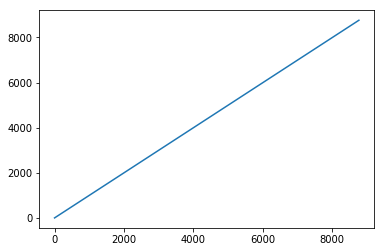

In [17]:
# !!! - ЭТО ВАЖНО
# Индексы у датафрейма Х теперь уникальные на каждую строку
# X = X.reset_index() - уже была операция
plt.figure
plt.plot(X.index)

# Создание признаков

## Поиск недостающих адресов

### Адреса без **address_rus**.  Транслитерация в русский язык и исправление

In [519]:
# Исправление адресов в хороший для поисковика вид,
# транслитерация в русский язык

# Grettings to. Use idea of:
# https://stackoverflow.com/questions/14173421/use-string-translate-in-python-to-transliterate-cyrillic
# https://github.com/aamamaev/machine-learning/blob/master/parsing/parsing_example.ipynb
# https://bitbucket.org/snippets/zubr/ke8Br5

with open('./data/dicts/dict_en2ru.json.txt', 'r') as outfile:  
    dict_en2ru = json.load(outfile)
    dict_en2ru = dict((re.escape(k), v) for k, v in  dict_en2ru.items())   # rep.iteritems())
    patt_en2ru = re.compile("|".join(dict_en2ru.keys()))

with open('./data/dicts/dict_cities.json.txt', 'r') as outfile:  
    dict_cities = json.load(outfile)
    dict_cities = dict((re.escape(k), v) for k, v in  dict_cities.items())   # rep.iteritems())
    patt_cities = re.compile("|".join(dict_cities.keys()))

with open('./data/dicts/dict_signs.json.txt', 'r') as outfile:  
    dict_signs = json.load(outfile)
    dict_signs = dict((re.escape(k), v) for k, v in  dict_signs.items())   # rep.iteritems())
    patt_signs = re.compile("|".join(dict_signs.keys()))
    
points = []
for s,ind in zip(X[X['lat'].isna()]['address'].values, X[X['lat'].isna()].index  ):
# for s,ind in tqdm(zip(X['address'].values, X.index  )):                                 !!!
    s = s.upper()
    ts = patt_signs.sub(lambda m: dict_signs[re.escape(m.group(0))], s)
    ts = patt_cities.sub(lambda m: dict_cities[re.escape(m.group(0))], ts)
    X.loc[ind,'address_translit'] = ts
    ts = patt_en2ru.sub(lambda m: dict_en2ru[re.escape(m.group(0))], ts)
    
#     print(ind, s, ts)
    points.append((ind, s, ts))
    X.loc[ind,'address_rus'] = ts
    
del s, ind, ts

8765it [00:28, 310.47it/s]


In [299]:
X.loc[3022]['address_translit']

' 33,  PROSPECT  KOMMUNISTICHESKAYA SAKHALINSK'

### Для всех банкоматов Парсинг инфы о зданиях, в которых они находятся

In [412]:
with open('./data/all_atms_info/_log.txt', 'w') as fp:  
    fp.write('index,id,address_rus\n')

In [445]:
import importlib
myutils = importlib.reload(myutils)

driver = webdriver.Chrome('chromedriver')

In [ ]:
length = len(X)

for i in range(length):
    with open('./data/all_atms_info/_log.txt', 'a') as fp:  
        line = str(i) + ';' + str(X.iloc[i]['id']) + ';' + str(X.iloc[i]['address_translit']) + ';'
        fp.write(line)
    
        print(i, X.iloc[i]['id'])
        info = []
        info.append(i)                   # index
        info.append(X.iloc[i]['id'])        # id
        info.append(myutils.get_near_info_strict(driver, X.iloc[i]['address_translit'], fp) )   # address_rus
        fp.write('\n')
        with open('./data/all_atms_info/info_'+str(i)+'.json.txt', 'w') as fp1:  
            json.dump(info, fp1, ensure_ascii=False)
    #     sleep_to = random.random()*1
    #     time.sleep(sleep_to)
    
del length

In [695]:
# Ввод спарсиных данных в общую таблицу
# for file in tqdm(glob.glob(os.path.join('./data/all_atms_info/**',"*.txt"))):
for file in glob.glob(os.path.join('./data/all_atms_info/**',"*.txt")):
    with open(file, 'r') as fp:  
        info_item = json.load(fp)
        if not info_item[2] is None:
            X.loc[X[X.id == info_item[1]].index, 'stops_count'] = np.int8(info_item[2][3])
            X.loc[X[X.id == info_item[1]].index, 'dist_to_stop'] = np.float(info_item[2][4])
            X.loc[X[X.id == info_item[1]].index, 'inplace_cats'] = str(info_item[2][5]).replace('\'','').replace('[','').replace(']','')
            if np.isnan(X.loc[X[X.id == info_item[1]].index, 'lat'].values[0]):
                if str(info_item[2][2][0]) == 'Маршрут' or len(info_item[2][2])<2 or np.isnan(np.float(info_item[2][2][0])) or np.isnan(np.float(info_item[2][2][1])):
                    pass
                else:
                    X.loc[X[X.id == info_item[1]].index, 'lat'] = np.float64(info_item[2][2][0])
                    X.loc[X[X.id == info_item[1]].index, 'long'] = np.float64(info_item[2][2][1])


### Добираем ещё данные

In [697]:
X.columns

# X.drop('lat_0', axis=1, inplace=True)
# X.drop('long_0', axis=1, inplace=True)
X.drop('lat_1', axis=1, inplace=True)
X.drop('long_1', axis=1, inplace=True)

Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'isTrain', 'count', 'count_latlong', 'stops_count', 'dist_to_stop',
       'inplace_cats'],
      dtype='object')

Те, которые плохо спарсены, прогоняем ещё разок: корректируем транслитерацию, а затем парсим в Яндексе инфу.

In [700]:
with open('./data/dicts/dict_correct.json.txt', 'r') as outfile:  
    dict_signs = json.load(outfile)
    dict_signs = dict((re.escape(k), v) for k, v in  dict_signs.items())   # rep.iteritems())
    patt_signs = re.compile("|".join(dict_signs.keys()))
    
for s,ind in zip(X[X['long'].isna()]['address_translit'].values, X[X['long'].isna()].index  ):
    s = s.upper()
    ts = patt_signs.sub(lambda m: dict_signs[re.escape(m.group(0))], s)
    X.loc[ind,'address_translit'] = ts

del s, ind, ts

In [407]:
X[X['long'].isna()][['address','address_rus', 'address_translit','isTrain']]

,address,address_rus,address_translit,isTrain
40,PER. BAZARNY 4 SPASSK-DALNY,ПЕР БАЗАРНЯ 4 СПАССК-ДАЛНЯ,PER BAZARNY 4 SPASSK DALNY,True
150,ABB 6B NAB-CHELNINSKIJ NAB.CHELNY,6Б НАБЕРЕЖНОЧЕЛНИНСКИЙ НАБЕРЕЖНИЙ ЧЕЛНЫ,6B NABEREZHNOCHELNINSKIJ NABEREZHNIY CHEL...,True
451,"KOMSOMOLSKAJA P.,2 MOSKVA",КОМСОМОЛСКАЯ П 2 МОСКВА,KOMSOMOLSKAJA P 2 MOSKVA,True
566,"D. 91, PR-KT OBVODNYI KAN ARKHANGELSK",91 ПРОСПЕCТ ОБВОДНЫЙ КАН АРXАНГЕЛСК,91 PROSPECT OBVODNYI KANAL ARKHANGELSK,True
603,"D. 1, UL. 50-I ARMII BRYANSK G",1 УЛИЦА 50-И АРМИИ БРЯНСК,1 ULITSA 50 I ARMII BRYANSK,True
888,"D. 116/2, UL. KRASNOARMEI KRASNODAR G",116/2 УЛИЦА КРАСНОАРМЕИСКАЯ КРАСНОДАР,116/2 ULITSA KRASNOARMEISKAYA KRASNODAR,True
893,"D. 19/1, MKR. UBILEINYI IRKUTSK G",19/1 МИКРОРАИОН УБИЛЕИНЫЙ ИРКУЦК,19/1 UBILEINYI IRKUTSK,True
1192,"SOSNOVAY ALLEYA, 601 Moskva",СОСНОВАЯ АЛЛЕЯ 601 МОСКВА,SOSNOVAY ALLEYA 601 MOSKVA,True
1466,101 LENINSKIY AV. MOSCOW,101 ЛЕНИНСКИЙ ПРОСПЕCТ МОСКВА,101 LENINSKIY PROSPECT MOSKVA,True
1467,64/2 LENINSKIY AV MOSCOW,64/2 ЛЕНИНСКИЙ ПРОСПЕCТ МОСКВА,64/2 LENINSKIY PROSPECT MOSKVA,True


In [21]:
import importlib
myutils = importlib.reload(myutils)
driver = webdriver.Chrome('chromedriver')

In [ ]:
for s,ind in zip(X[X['long'].isna()]['address_translit'].values, X[X['long'].isna()].index  ):
    print(ind)

    info = []
    info.append(ind)                   # index
    info.append(X.iloc[ind]['id'])        # id
    info.append(myutils.get_near_info_strict(driver, X.loc[ind,'address_translit'] ))
    with open('./data/dobor_0_info/info_'+str(ind)+'.json.txt', 'w') as fp:  
        json.dump(info, fp, ensure_ascii=False)
    sleep_to = random.random()*2
    time.sleep(sleep_to)

In [ ]:
# Ввод спарсиных данных в общую таблицу
print(len(glob.glob(os.path.join('./data/dobor_0_info',"*.txt"))))
for file in glob.glob(os.path.join('./data/dobor_0_info',"*.txt")):
    with open(file, 'r') as fp:  
        info_item = json.load(fp)
        if not info_item[2] is None:
            print(info_item[0], info_item[2][0], info_item[2][1],  X.loc[X[X.id == info_item[1]].index, 'address'].values )
            
            X.loc[X[X.id == info_item[1]].index, 'stops_count'] = np.int8(info_item[2][3])
            X.loc[X[X.id == info_item[1]].index, 'dist_to_stop'] = np.int8(info_item[2][4])
            X.loc[X[X.id == info_item[1]].index, 'inplace_cats'] = str(info_item[2][5]).replace('\'','').replace('[','').replace(']','')
#             print(np.isnan(X.loc[X[X.id == info_item[1]].index, 'lat'].values[0]), X.loc[X[X.id == info_item[1]].index, 'lat'].values[0])
            if np.isnan(X.loc[X[X.id == info_item[1]].index, 'lat'].values[0]):
                if str(info_item[2][2][0]) == 'Маршрут' or len(info_item[2][2])<2 or np.isnan(np.float(info_item[2][2][0])) or np.isnan(np.float(info_item[2][2][1])):
                    pass
                else:
                    X.loc[X[X.id == info_item[1]].index, 'lat_1'] = np.float64(info_item[2][2][0])
                    X.loc[X[X.id == info_item[1]].index, 'long_1'] = np.float64(info_item[2][2][1])

In [413]:
X[X['long'].isna() & X['long_1'].isna()][['address','address_rus', 'address_translit','isTrain']]

,address,address_rus,address_translit,isTrain
3782,J.KUDRIAVOGO 24 KHANDYGA,Я КУДРИАВОГО 24 XАНДЫГА,J KUDRIAVOGO 24 KHAND;GA,True


In [23]:
for s,ind in zip(X[X['long'].isna() & X['long_1'].isna()]['address'].values, X[X['long'].isna() & X['long_1'].isna()].index  ):
    print(s, ind)

    info = []
    info.append(ind)                   # index
    info.append(X.iloc[ind]['id'])        # id
    info.append(myutils.get_near_info_strict(driver, X.loc[ind,'address_rus'] ))
    with open('./data/dobor_0_info/info_'+str(ind)+'.json.txt', 'w') as fp:  
        json.dump(info, fp, ensure_ascii=False)
    sleep_to = random.random()*2
    time.sleep(sleep_to)

J.KUDRIAVOGO 24           KHANDYGA     3782
Нет заголовка-описания точки
Нет поля "Остановки"


In [25]:
X.loc[X[X['long'].isna()].index, 'lat']  =  X.loc[X[X['long'].isna()].index, 'lat_1']
X.loc[X[X['long'].isna()].index, 'long'] =  X.loc[X[X['long'].isna()].index, 'long_1']

#### Есть ли кривые координаты?

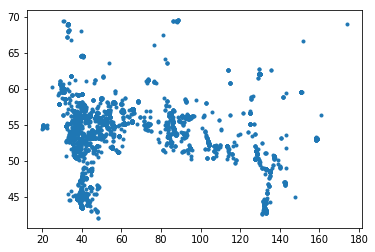

In [13]:
plt.figure
plt.plot(X['long'], X['lat'], '.')

Можно условиться, что все координаты верные, потому что они в России. На самом деле конечно это надо проверять вручную.

## Ввод данных в датафрейм

### Количество остановок рядом и расстояние до ближайшей

In [391]:
X['stops_count'].fillna(-1, inplace=True)
X['dist_to_stop'].fillna(X['dist_to_stop'].max() + 500, inplace=True)

### Количество банкоматов стоящих по одному адресу

In [12]:
counts_ru = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})
counts_en = X.groupby('address')['id'].count().reset_index().rename(columns={'id':'count'})

X = pd.merge(X, counts_en, how='left', on='address')
X = pd.merge(X, counts_ru, how='left', on='address_rus')

X.loc[X['count_y'].isna(),'count_y'] = X[X['count_y'].isna()]['count_x']

X.rename(columns={'count_y':'count'}, inplace=True)
X.drop('count_x', axis=1, inplace=True)
# X = X.reindex(index = range(len(X)))
# X = X.reset_index()

### Расстояния до ближайших банкоматов

Часть кода была в baseline организаторов

In [352]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [324]:
knc = KNeighborsClassifier(metric=distance,  n_jobs=-1)
dots = X[['lat','long']].dropna()
knc.fit(X=dots , y=np.ones(dots.shape[0]))
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6)

In [328]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]
    dots['var_%d'%i] = dots.iloc[:,dots.columns.str.contains('distance')].var(axis=1)

In [329]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)
dots['median'] = dots.iloc[:,dots.columns.str.contains('distance')].median(axis=1)

In [330]:
dots.drop(['lat', 'long'], axis=1, inplace=True)
X = pd.concat([X,dots], axis=1)
X.drop('var_1', axis=1, inplace=True)

### Город размещения

In [37]:
# получаем первую пачку населённых пунктов.
cities = pd.DataFrame( X[~X.address.isnull()].address.apply(lambda x: x.split()[-1]))
cities.rename(columns = {'address':'city'}, inplace=True)

# Убираем лишние символы из названий
def b(text):
    for ch in ['0','1','2','3','4','5','6','7','8','9','/','-','.','!',',','\'',' ']:
        if ch in text:
            text = text.replace(ch,"")
    return text
cities['city'] = cities['city'].apply(lambda x: b(x) )
cities.city = cities.city.str.upper()

In [38]:
# выясняем где проблемы
# print(pd.unique(cities[cities.city.str.len() < 2].values.ravel('K')))
print(pd.unique(cities[cities.city.str.len() < 5].values.ravel('K')))

['OMSK' 'EYSK' 'TVER' 'TULA' 'NOVG' 'SULI' 'PERM' 'ORSK' 'UFA' 'BOR' 'G'
 'P' 'TAGI' 'RP' 'S' 'PGT' 'POSA' 'N' 'KL' 'SELO' 'ZEYA' 'LOMO' 'POL'
 'LGOV' 'OB' 'ELEC' 'LUKI' 'ST' 'D' 'PG' 'MKR' 'R' 'KHOR' 'RUSS' 'VAD'
 'KUT' 'UYAR' 'UMBA' 'AZOV' 'GORO' 'AK' 'ISSA' 'GORB' 'KLIN' 'RN' 'KUPA'
 'PO' 'CH' 'MAYA' 'YA' 'MO' 'OBL' 'KAME' 'OREL' 'PYS' 'TARA' 'GP' 'IGRA'
 'VEL' 'OHA' 'M' 'MAYN' 'SLOB']


 S - selo, G - gorod, P - poselok, D - derevnya, R - PGT, derevnya, M - mirkorayon, подмосковье

In [39]:
cities = myutils.upgrade_cities(X, cities)
X['city'] = cities

X.loc[X[X['address_rus'].str.find('станица Павловская')>-1].index]['city'] = 'PAVLOVSKAYA'
X.loc[X[X['address_rus'].str.find('Ростов-на-Дону')>-1].index]['city'] = 'ROSTOVNADONU'

### LabelEncode для городов размещения

In [42]:
import sklearn.preprocessing # import LabelEncoder, OneHotEncoder
label_encoder = sklearn.preprocessing.LabelEncoder()
X['city_lab'] = pd.Series(label_encoder.fit_transform(X['city']))

### Редкие города

In [43]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index
X['rare_city'] = X.city.apply(lambda x: 1 if x in rare_cities else 0)
X.rare_city= X.city.rank().fillna(0)

### Количество банкоматов в городе

In [44]:
X['bankomat_city_count'] = X['city'].map(X.groupby('city').size())

###  Категории зданий, в которых находятся банкоматы

In [46]:
for ind, item in zip(X.index, X['inplace_cats']):
    if not type(item) == float:
        for el in item.split(', '):
            X.loc[ind, 'cat_'+el] = 1

In [47]:
filter_col = [col for col in X if col.startswith('cat_')]
for col in filter_col:
    X[col].fillna(0, inplace=True)

### Количество в одной точке, определённое по координатам, а не адресу

In [ ]:
# не очень сильный признак.
counts_latlong = X.groupby(['lat','long'])['id'].count().reset_index().rename(columns={'id':'count_latlong'})
X = pd.merge(X, counts_latlong, how='left', on=['lat','long'])

# Сохраняем/загружаем данные

In [6]:
# X.to_csv('./data/X_categories.csv')
# X = pd.DataFrame.from_csv('./data/X_categories.csv')

/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """
/home/ivan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


# Изучаю Данные

* Популярность это функция от количества операций с этим банкоматом
* atm_group = 8083 -- группа банкоматов РОСБАНКА
* Id формировался на основе atm_group и уникального внутри каждой группы id банкомата. X.sort_values('id') даст Вам понимание его структуры.
* под банками партнерами подразумевается: а) у них беспроцентное снятие денег со счетов Росбанка

In [8]:
X.info(max_cols=2000)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8765 entries, 0 to 8764
Data columns (total 1106 columns):
id                                                              8765 non-null float64
atm_group                                                       8765 non-null float64
address                                                         8765 non-null object
address_rus                                                     8403 non-null object
lat                                                             8765 non-null float64
long                                                            8765 non-null float64
target                                                          6261 non-null float64
isTrain                                                         8765 non-null bool
count                                                           8765 non-null float64
count_latlong                                                   8345 non-null float64
stops_count                         

In [11]:
X.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain,count,count_latlong,...,indexes_3,var_3,distance_4,indexes_4,var_4,distance_5,indexes_5,var_5,mean,median
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,1.0,1.0,...,3757,2.217654e-02,0.461430,2933,0.018374,0.558967,8755,0.020805,0.409042,0.447444
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1.0,1.0,...,8288,6.635188e-02,0.721148,6328,0.052634,0.903549,4461,0.059939,0.647652,0.720783
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,1.0,1.0,...,2517,8.312963e-03,0.236330,6810,0.006674,0.304450,3702,0.007817,0.209586,0.221691
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,1.0,1.0,...,5221,2.888895e-34,0.121670,5218,0.000000,0.136764,6490,0.000046,0.124689,0.121670
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,1.0,1.0,...,3566,1.119856e-02,0.610316,2305,0.028436,0.878445,1061,0.068438,0.490170,0.394887


### Распределение банкоматов по банкам

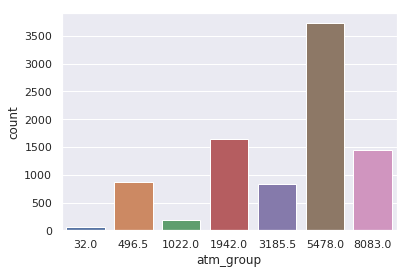

In [49]:
sns.countplot(x='atm_group', data=X ) #[X['isTrain']==True])

# r = range( len(X['atm_group'].unique()))
# plt.figure()
# plt.bar(r, X.groupby('atm_group')['atm_group'].count().values)
# plt.xticks(ticks=r, labels = X['atm_group'].unique())
# plt.title('Количество банкоматов разных банков')
# plt.grid(True)
# del r

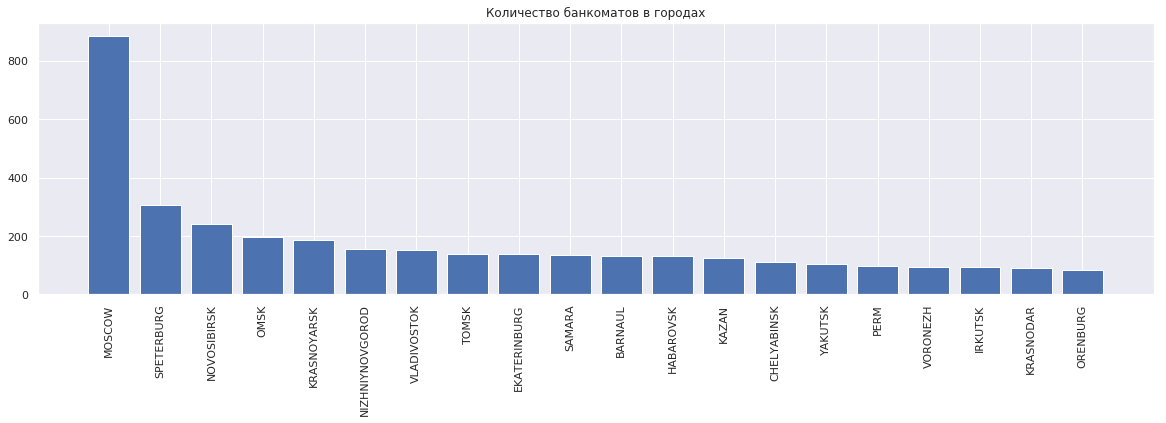

In [53]:
r = 20
plt.figure(figsize=(20,5))
plt.bar(X.groupby('city').size().sort_values(ascending=False).index[:r], 
        X.groupby('city').size().sort_values(ascending=False).values[:r])
plt.xticks(rotation='vertical' )
plt.title('Количество банкоматов в городах')
del r

### В каких местах размещены банкоматы?

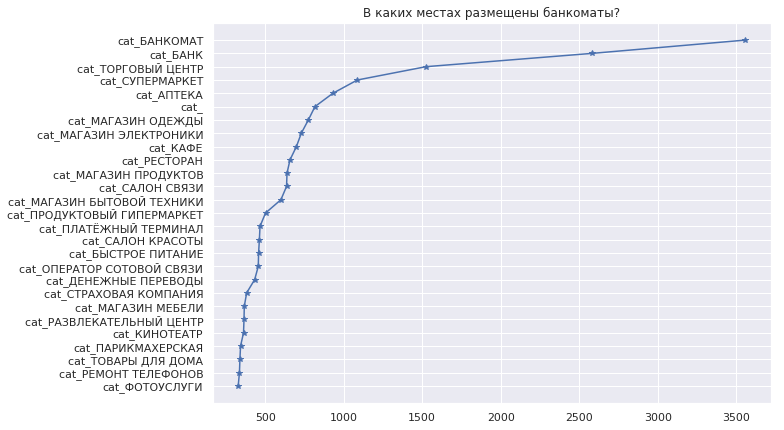

In [224]:
temp_df = pd.DataFrame(columns=['col','count'])
filter_col = [col for col in X if col.startswith('cat_')]
for col in filter_col:
    temp_df = temp_df.append( pd.DataFrame([ [col, X[col].sum()] ], columns=['col','count']) )

count = 25
plt.figure(figsize=(10,7))
plt.plot(temp_df.sort_values(by='count', ascending=True)[-count-2:]['count'],
         temp_df.sort_values(by='count', ascending=True)[-count-2:]['col'].values, '-*')
plt.grid(True)
plt.title('В каких местах размещены банкоматы?')

del count
del temp_df

Первые два: банкоматы и банки - очевидно. А дальше что нужно людям? **Хлеба и электроники**

### Распределение *target* в зависимости от банка

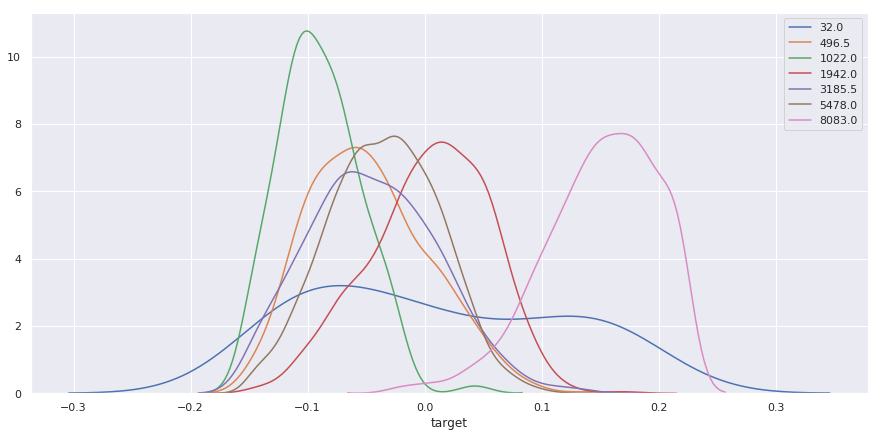

In [95]:
f, axes = plt.subplots(1, 1, figsize=(15, 7))
for name, group in X.groupby('atm_group'):
    sns.distplot(group[group['isTrain']==True]['target'], hist=False, rug=False, label=str(name), ax=axes)
plt.legend()

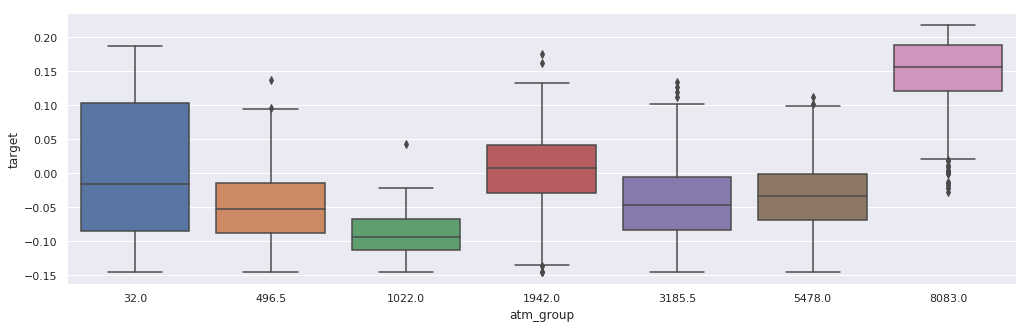

In [83]:
f, axes = plt.subplots(1, 1, figsize=(17, 5))

sns.boxplot(x="atm_group", y="target",
#             hue="smoker", 
#             palette=["m", "g"],
            data=X, ax=axes)

Банкомат моего банка очевидно лучше:

Клиенты точно знают, что они могут тут воспользоваться, а у партнёров может быть чего-то нету, либо клиент об этом не знает.

### Распределение *target* в зависимости от города

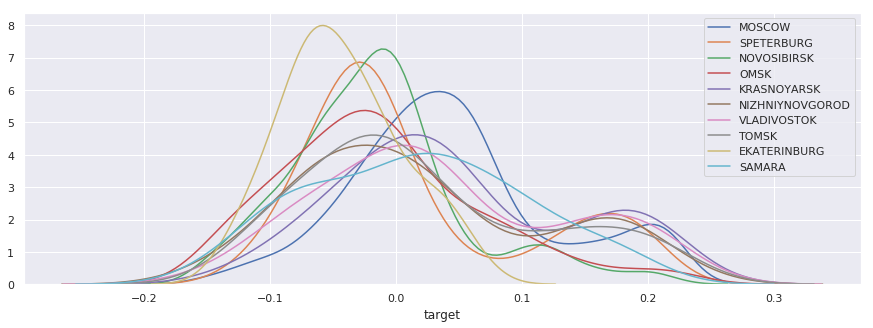

In [7]:
r = 10
f, axes = plt.subplots(1, 1, figsize=(15, 5))
for city in X.groupby('city').size().sort_values(ascending=False).index[:r]:
    sns.distplot( X[(X['city']==city)&(X['isTrain']==True)]['target'], 
                 hist=False, rug=False, label=city, ax=axes)
plt.legend()

### Распределение *target* в зависимости от категорий зданий

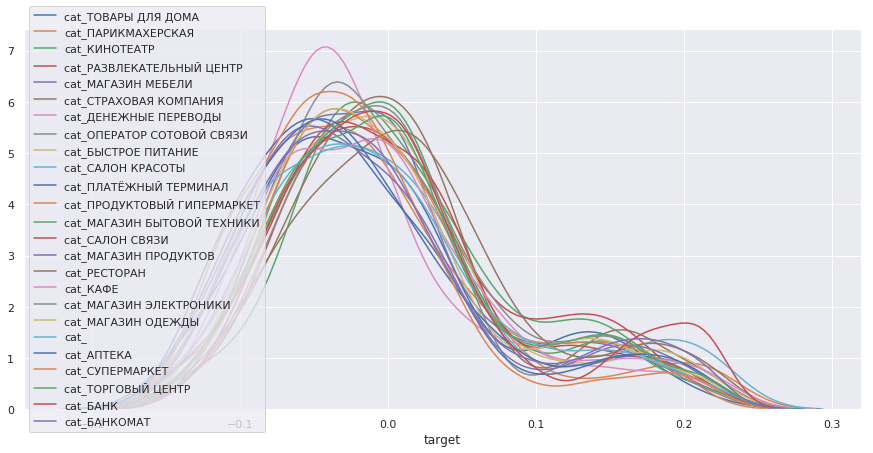

In [10]:
count = 25

temp_df = pd.DataFrame(columns=['col','count'])
filter_col = [col for col in X if col.startswith('cat_')]
for col in filter_col:
    temp_df = temp_df.append( pd.DataFrame([ [col, X[col].sum()] ], columns=['col','count']) )

temp_cats = temp_df.sort_values(by='count', ascending=True)[-count:]['col'].values

f, axes = plt.subplots(1, 1, figsize=(15, 7))
for col in temp_cats:
    sns.distplot( X[(X[col]==1)&(X['isTrain']==True)] ['target'], 
                 hist=False, rug=False, label=col, ax=axes)
plt.legend(loc='center left')
del temp_df

Интересно, что категория здания особо не влияет на рейтинг. Т.е. можно ставить банкомат где угодно. (Хотя наличие банкомата в банке вроде как и очевидно)

### Распределение *target* в зависимости от количества банкоматов в одном месте?

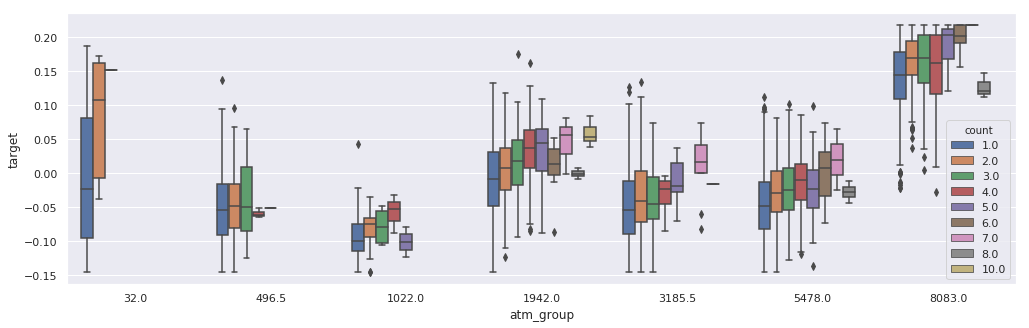

In [420]:
f, axes = plt.subplots(1, 1, figsize=(17, 5))

sns.boxplot(x="atm_group", y="target", hue='count', data=X, ax=axes)

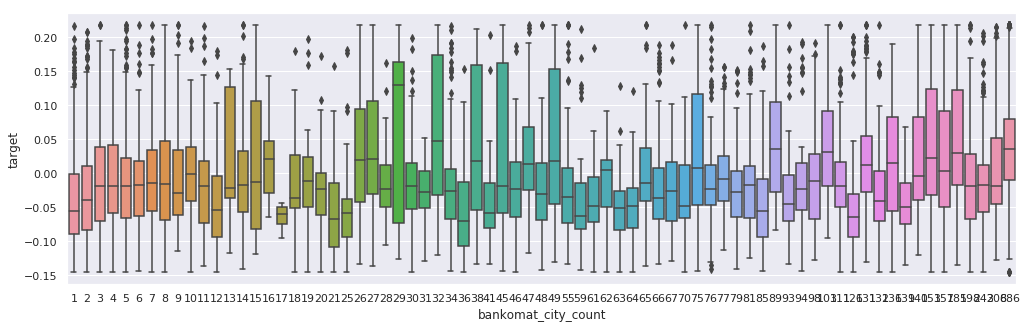

In [424]:
f, axes = plt.subplots(1, 1, figsize=(17, 5))
sns.boxplot(x="bankomat_city_count", y="target", data=X, ax=axes)

#### **Расстояния до остановок в больших и малых городах?**

Не однозначно

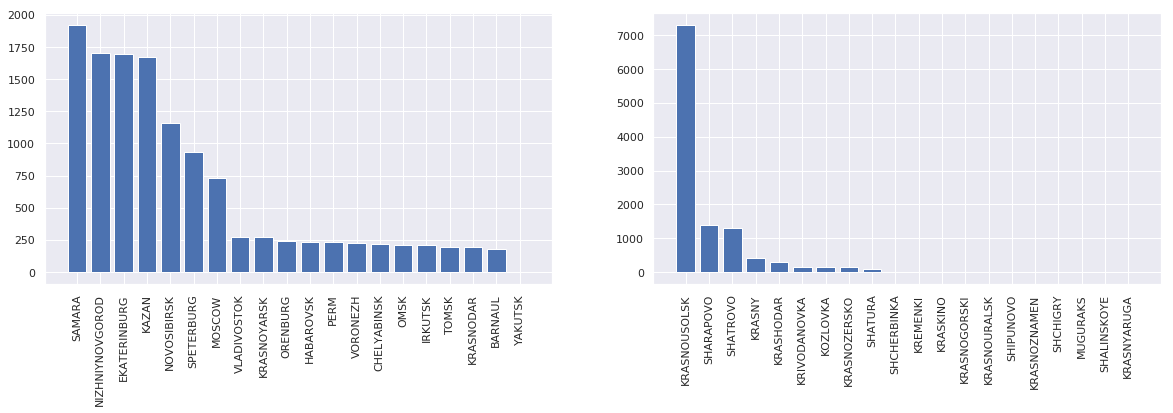

In [251]:
r = 20

indexes = X.groupby('city').size().sort_values(ascending=False).index[:r]
# print(indexes)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.bar(X[X['city'].isin (indexes)].groupby('city')['dist_to_stop'].mean().sort_values(ascending=False).index[:r], 
        X[X['city'].isin (indexes)].groupby('city')['dist_to_stop'].mean().sort_values(ascending=False).values[:r])
plt.xticks(rotation='vertical' )
# plt.title('')

indexes = X.groupby('city').size().sort_values(ascending=True).index[:r]

plt.subplot(122)
plt.bar(X[X['city'].isin (indexes)].groupby('city')['dist_to_stop'].mean().sort_values(ascending=False).index[:r], 
        X[X['city'].isin (indexes)].groupby('city')['dist_to_stop'].mean().sort_values(ascending=False).values[:r])
plt.xticks(rotation='vertical' )


del r

#### Матрица корреляций - мало что скажет

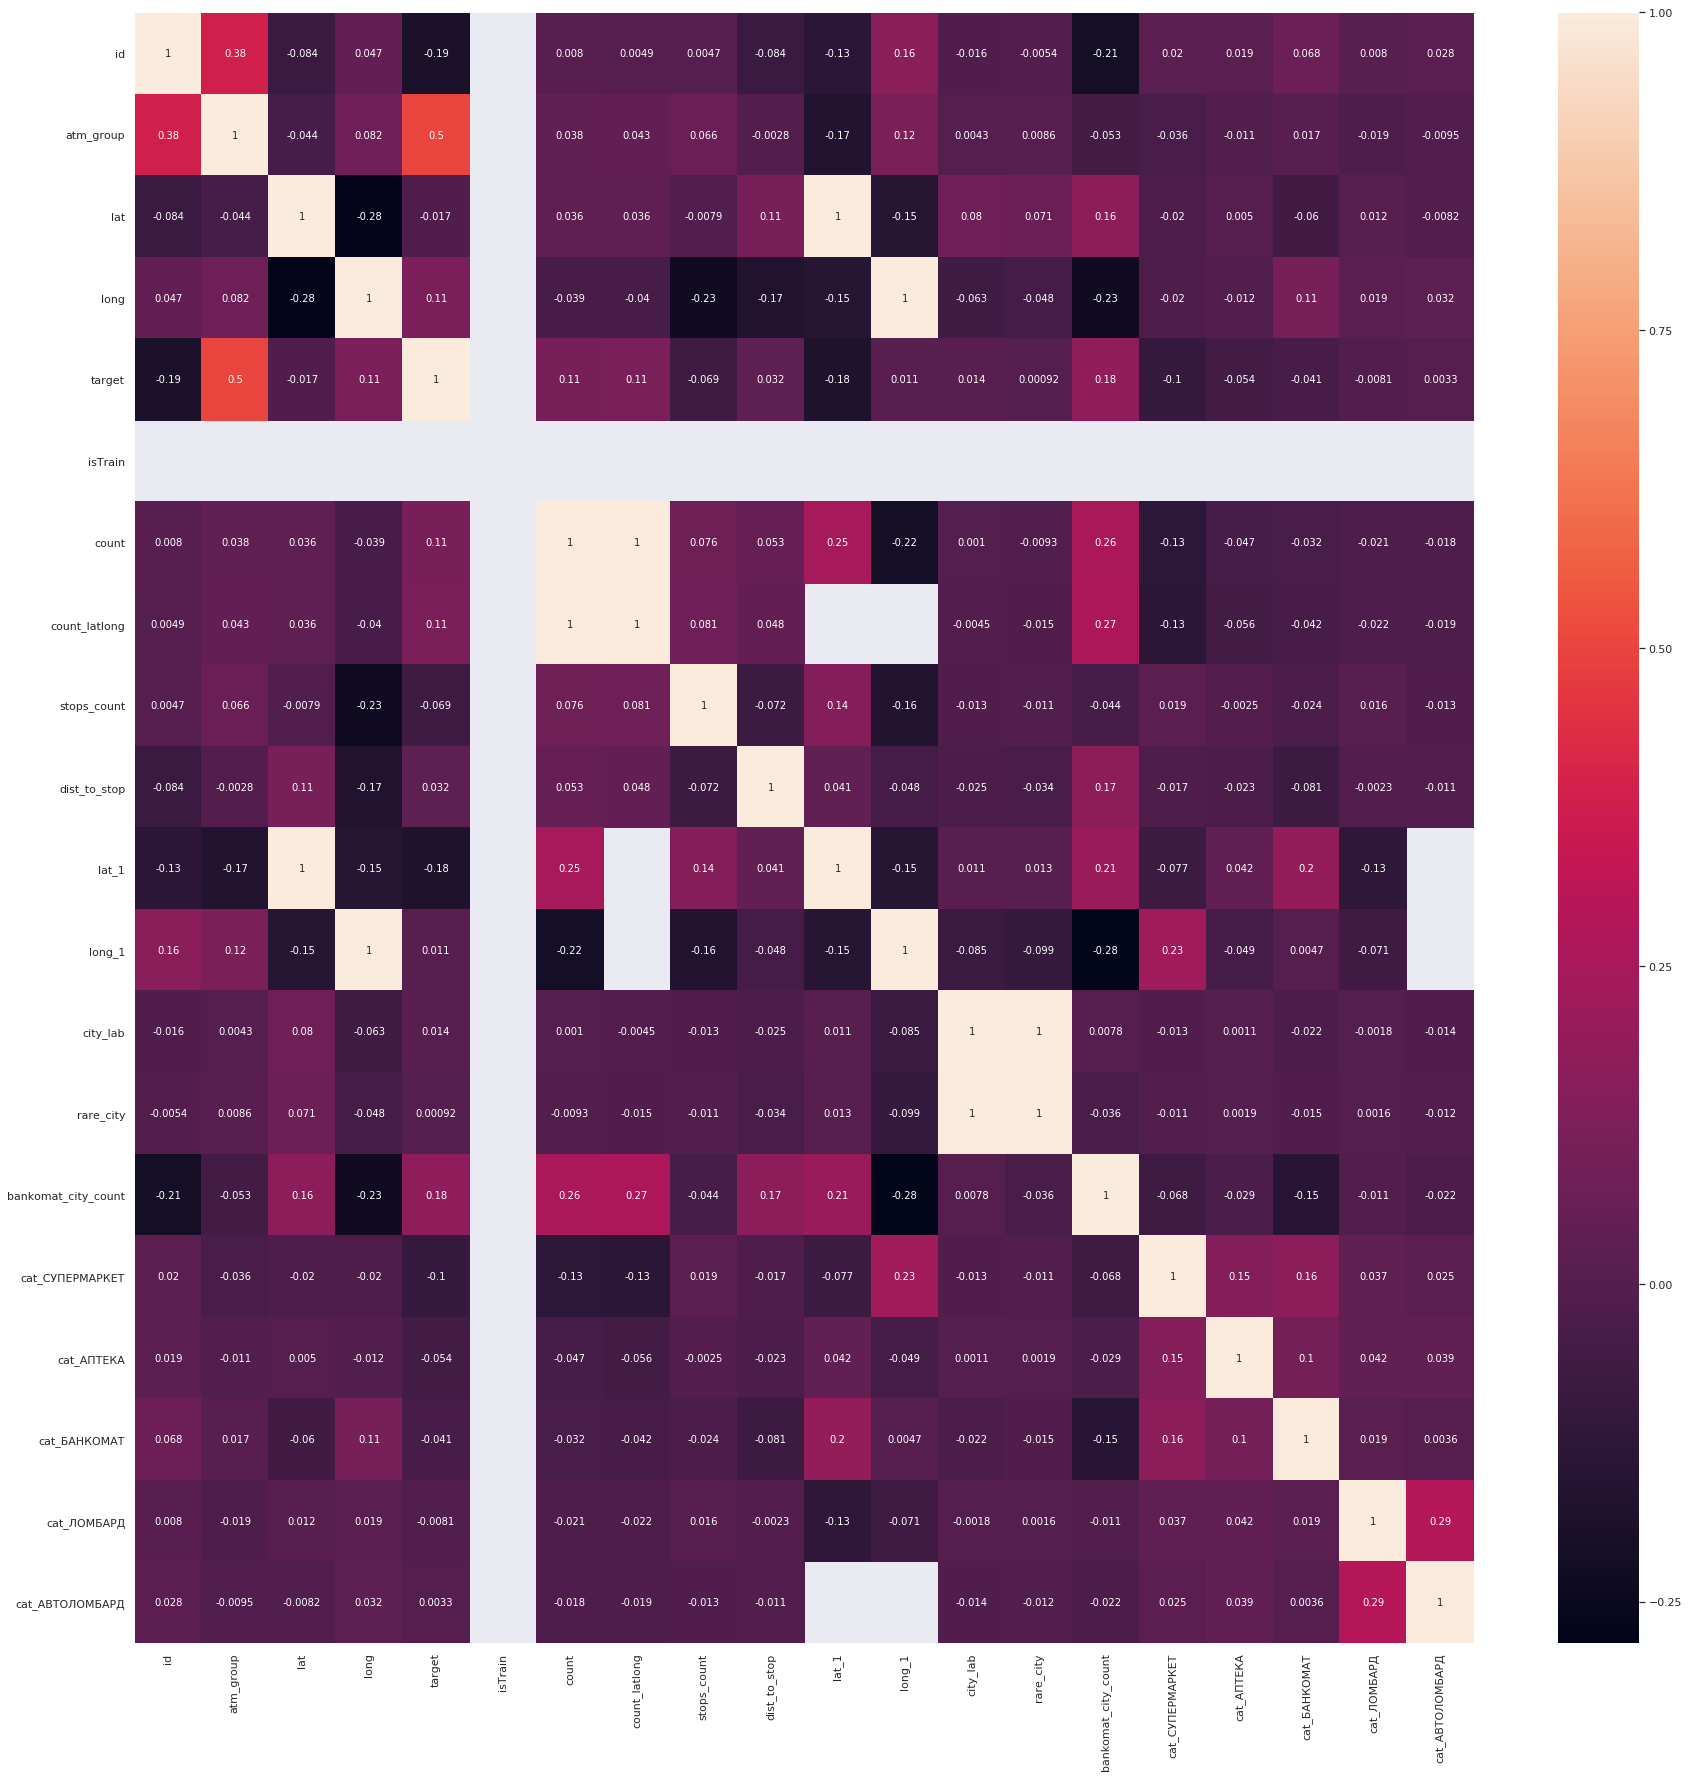

In [45]:
cols = X.columns[:25]

plt.figure(figsize=(30,30))
# plt.subplot(211)
sns.heatmap(X[X.isTrain][cols].corr('pearson'), annot= True)
# sns.heatmap(X[X.isTrain][cols].corr('pearson'), annot= True, mask = mask)
# sns.heatmap(X[X.isTrain][cols].corr('pearson'), xticklabels=cols, yticklabels=cols, annot= True, mask = mask)
# plt.subplot(212)
# sns.heatmap(X[X.isTrain][cols].corr('kendall'), annot= True)
# sns.heatmap(X[X.isTrain][cols].corr('kendall'), xticklabels=cols, yticklabels=cols, annot= True, mask = mask)

### Попытка понять что значит *id*

In [425]:
X.sort_values(['id','atm_group']) [['id','atm_group','address']]

,id,atm_group,address
7295,1.0,32.0,"MARATA, 17 S.PETERBURG"
6293,2.0,32.0,"TYUSHINA, 11 ST.PETERSBURG"
6739,3.0,1022.0,ABB 5 M.DZHALILYA N.SHIGALEEVO
6488,4.0,496.5,PUSHKINA 15 ELISTA
2606,5.0,496.5,BUDENNOGO 7A ELISTA
2607,6.0,496.5,"HO CHI MIHN AVE, 19 ULYANOVSK"
5126,7.0,496.5,SHELESTA 116A KHABAROVSK
2608,8.0,496.5,ORDZHONIKIDZE 52 YAKUTSK
8462,9.0,496.5,3-RD DACHNAYA SARATOV
2609,10.0,496.5,"VETERANOV AVE, 3 KRASNOKAMENS"


# Попытка чистить данные, убирая выбросы

Выяснилось, что изначально в данных есть большая проблема с русскими адресами - они не соответствуют латинице. 
Искать геолоакцию основываясь на русских адресах, которые дали организаторы - совершенно проблемно. **Нужно делать свою транслитерацию поля *address*.**


**Чистка данных идёт по следующему алгоритму:**
 - смотрим расположение банкоматов по городам (успел сделать только 25 самых больших городов):
     - отдельно по *lat*
     - отдельно по *long*
 - выбираем те, которые сильно выбиваются из общей массы
 - для отобранных:
     - транслитерация поля *address* (результат помещаем в *address_translit*)
     - парсинг данных по новым адресам *address_translit*

In [15]:
import importlib
myutils = importlib.reload(myutils)

driver = webdriver.Chrome('chromedriver')

In [3]:
# Исправление адресов в хороший для поисковика вид,
# транслитерация в русский язык

# Grettings to. Use idea of:
# https://stackoverflow.com/questions/14173421/use-string-translate-in-python-to-transliterate-cyrillic
# https://github.com/aamamaev/machine-learning/blob/master/parsing/parsing_example.ipynb
# https://bitbucket.org/snippets/zubr/ke8Br5

def set_translit():
    with open('./data/dicts/dict_en2ru.json.txt', 'r') as outfile:  
        dict_en2ru = json.load(outfile)
        dict_en2ru = dict((re.escape(k), v) for k, v in  dict_en2ru.items())   # rep.iteritems())
        patt_en2ru = re.compile("|".join(dict_en2ru.keys()))

    with open('./data/dicts/dict_cities.json.txt', 'r') as outfile:  
        dict_cities = json.load(outfile)
        dict_cities = dict((re.escape(k), v) for k, v in  dict_cities.items())   # rep.iteritems())
        patt_cities = re.compile("|".join(dict_cities.keys()))

    with open('./data/dicts/dict_signs.json.txt', 'r') as outfile:  
        dict_signs = json.load(outfile)
        dict_signs = dict((re.escape(k), v) for k, v in  dict_signs.items())   # rep.iteritems())
        patt_signs = re.compile("|".join(dict_signs.keys()))

    points = []

    # for s,ind in tqdm(zip(X['address'].values, X.index  )):
    for s,ind in tqdm(zip(X[ind_cond_lat]['address'].values, 
                          X[ind_cond_lat].index  )):
        s = s.upper()
        ts = patt_signs.sub(lambda m: dict_signs[re.escape(m.group(0))], s)
#         print(ts)
        ts = patt_cities.sub(lambda m: dict_cities[re.escape(m.group(0))], ts)
#         print(ts)
        X.loc[ind,'address_translit'] = ts
        ts = patt_en2ru.sub(lambda m: dict_en2ru[re.escape(m.group(0))], ts)
        points.append((ind, s, ts))
        X.loc[ind,'address_rus'] = ts

    for s,ind in tqdm(zip(X[ind_cond_long]['address'].values, 
                          X[ind_cond_long].index  )):
        s = s.upper()
        ts = patt_signs.sub(lambda m: dict_signs[re.escape(m.group(0))], s)
        ts = patt_cities.sub(lambda m: dict_cities[re.escape(m.group(0))], ts)
        X.loc[ind,'address_translit'] = ts
        ts = patt_en2ru.sub(lambda m: dict_en2ru[re.escape(m.group(0))], ts)
        points.append((ind, s, ts))
        X.loc[ind,'address_rus'] = ts

    del s, ind, ts

Смотрю распределение положения банкоматов по городам.

UFA


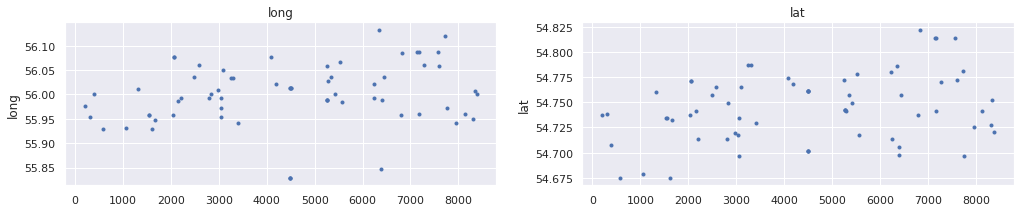

In [11]:
city_ir = 30
ind_cond_long = (X['city'] == city) & (X['long'] > 80) 
ind_cond_lat = (X['city'] == city) & (X['lat'] > 60)
city = X.groupby('city').size().sort_values(ascending=False).index[city_ir]
print(city)

plt.figure(figsize=(17,3))
plt.clf()
plt.subplot(121)
plt.title('long'), plt.ylabel('long'), plt.plot( X[(X['city'] == city)]['long'], '.')
plt.plot( X[ ind_cond_long ]['long'], 'r.')
plt.subplot(122)
plt.title('lat'),  plt.ylabel('lat'),  plt.plot( X[(X['city'] == city)]['lat'], '.')
plt.plot( X[ ind_cond_lat ]['lat'], 'r.')
plt.show()



Убираю выбросы (успел сделать только 25 самых больших городов):
 - транслитерация поля *address*
 - парсинг данных по новым адресам

In [357]:
set_translit()

2it [00:00, 206.53it/s]
89it [00:00, 382.36it/s]


In [431]:
X[ind_cond_long][['id', 'atm_group', 'address', 'address_rus', 'address_translit', 'lat', 'long']]

,id,atm_group,address,address_rus,address_translit,lat,long
3164,5732.0,5478.0,"D. 78, LIT. A, UL. PERMYA TYUMEN G","река Сельмачилькикэ 2- я, Красноселькупский ра...",NaN,63.584404,82.824472
3165,5733.0,5478.0,"D. 78, LIT. A, UL. PERMYA TYUMEN G","река Сельмачилькикэ 2- я, Красноселькупский ра...",NaN,63.584404,82.824472
3166,5734.0,5478.0,"D. 78, LIT. A, UL. PERMYA TYUMEN G","река Сельмачилькикэ 2- я, Красноселькупский ра...",NaN,63.584404,82.824472
5977,7698.0,5478.0,"D. 10, KORP. 2, UL. SERGE TYUMEN G","болото Лимпыпытэльто Сэр, Красноселькупский ра...",NaN,64.100519,81.779030


In [432]:
X[ind_cond_lat][['id', 'atm_group', 'address', 'address_rus', 'address_translit', 'lat', 'long']]

,id,atm_group,address,address_rus,address_translit,lat,long
3164,5732.0,5478.0,"D. 78, LIT. A, UL. PERMYA TYUMEN G","река Сельмачилькикэ 2- я, Красноселькупский ра...",NaN,63.584404,82.824472
3165,5733.0,5478.0,"D. 78, LIT. A, UL. PERMYA TYUMEN G","река Сельмачилькикэ 2- я, Красноселькупский ра...",NaN,63.584404,82.824472
3166,5734.0,5478.0,"D. 78, LIT. A, UL. PERMYA TYUMEN G","река Сельмачилькикэ 2- я, Красноселькупский ра...",NaN,63.584404,82.824472
5661,5593.0,5478.0,"D. 23, UL. CHERVISHEVSKII TYUMEN G","СОПК Монтажник-II, 21, Нижневартовский район, ...",NaN,61.001378,76.574730
5977,7698.0,5478.0,"D. 10, KORP. 2, UL. SERGE TYUMEN G","болото Лимпыпытэльто Сэр, Красноселькупский ра...",NaN,64.100519,81.779030


In [360]:
for i in X[ind_cond_lat ].index:
    with open('./data/all_atms_info/_log.txt', 'a') as fp:  
        line = str(i) + ';' + str(X.iloc[i]['id']) + ';' + str(X.iloc[i]['address_translit']) + ';'
        fp.write(line)
    
        print(i, X.iloc[i]['id'], X.iloc[i]['address_translit'])
        info = []
        info.append(i)                   # index
        info.append(X.iloc[i]['id'])        # id
        info.append(myutils.get_near_info_strict(driver, X.iloc[i]['address_translit'], fp) )
        fp.write('\n')
        with open('./data/all_atms_info/info_'+str(i)+'.json.txt', 'w') as fp1:  
            json.dump(info, fp1, ensure_ascii=False)
            
    # сразу добавляем
    file = str('./data/all_atms_info/info_')+str(i)+str('.json.txt')
    with open(file, 'r') as fp1:  
        info_item = json.load(fp1)
        if not info_item[2] is None:
            X.loc[X[X.id == info_item[1]].index, 'stops_count'] = np.int8(info_item[2][3])
            X.loc[X[X.id == info_item[1]].index, 'dist_to_stop'] = np.float(info_item[2][4])
            X.loc[X[X.id == info_item[1]].index, 'inplace_cats'] = str(info_item[2][5]).replace('\'','').replace('[','').replace(']','')
            if str(info_item[2][2][0]) == 'Маршрут' or len(info_item[2][2])<2 or np.isnan(np.float(info_item[2][2][0])) or np.isnan(np.float(info_item[2][2][1])):
                pass
            else:
                X.loc[X[X.id == info_item[1]].index, 'lat'] = np.float64(info_item[2][2][0])
                X.loc[X[X.id == info_item[1]].index, 'long'] = np.float64(info_item[2][2][1])


2485 4316.0 KHUTOR KOPANSKOY, 85   KRASNODAR      
3646 3713.0 BALASHIHAO, 100     KRASNODAR      


In [273]:
for i in X[ ind_cond_long ].index:
    with open('./data/all_atms_info/_log.txt', 'a') as fp:  
        line = str(i) + ';' + str(X.iloc[i]['id']) + ';' + str(X.iloc[i]['address_translit']) + ';'
        fp.write(line)
    
        print(i, X.iloc[i]['id'])
        info = []
        info.append(i)                   # index
        info.append(X.iloc[i]['id'])        # id
        info.append(myutils.get_near_info_strict(driver, X.iloc[i]['address_translit'], fp) )
#         info.append(myutils.get_near_info_strict(driver, X.iloc[i]['address_rus'], fp) )
        fp.write('\n')
        with open('./data/all_atms_info/info_'+str(i)+'.json.txt', 'w') as fp1:  
            json.dump(info, fp1, ensure_ascii=False)
            
    # сразу добавляем
    file = str('./data/all_atms_info/info_')+str(i)+str('.json.txt')
    with open(file, 'r') as fp1:  
        info_item = json.load(fp1)
        if not info_item[2] is None:
            X.loc[X[X.id == info_item[1]].index, 'stops_count'] = np.int8(info_item[2][3])
            X.loc[X[X.id == info_item[1]].index, 'dist_to_stop'] = np.float(info_item[2][4])
            X.loc[X[X.id == info_item[1]].index, 'inplace_cats'] = str(info_item[2][5]).replace('\'','').replace('[','').replace(']','')
            if str(info_item[2][2][0]) == 'Маршрут' or len(info_item[2][2])<2 or np.isnan(np.float(info_item[2][2][0])) or np.isnan(np.float(info_item[2][2][1])):
                pass
            else:
                X.loc[X[X.id == info_item[1]].index, 'lat'] = np.float64(info_item[2][2][0])
                X.loc[X[X.id == info_item[1]].index, 'long'] = np.float64(info_item[2][2][1])


2107 7194.0
4319 4926.0
4388 5456.0
7241 4143.0
7401 5531.0


### Сохраняем чищенные данные и далее используем их

In [4]:
# X.to_csv('./data/X_clean.csv')
X = pd.DataFrame.from_csv('./data/X_clean.csv')

/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


# Train-,Test- выборки

In [13]:
drop_cols = ['target', 'isTrain', 'address', 'address_rus', 'address_translit', 'inplace_cats', 'city',
             'lat_1', 'long_1', 'count_latlong', 'cat_', 'stops_count', 'dist_to_stop',
             'indexes_1', 
             'distance_2',
             'indexes_2', 'var_2', 'distance_3', 'indexes_3', 'var_3', 'distance_4',
             'indexes_4', 'var_4', 'distance_5', 'indexes_5', 'var_5']

X_ = X[X.isTrain].drop(drop_cols, axis=1)
Y_ = X.loc[X.isTrain, 'target']
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.2, random_state=1)

In [14]:
X_train.info(max_cols=2000)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5008 entries, 2161 to 5157
Data columns (total 1080 columns):
id                                                              5008 non-null float64
atm_group                                                       5008 non-null float64
lat                                                             5008 non-null float64
long                                                            5008 non-null float64
count                                                           5008 non-null float64
city_lab                                                        5008 non-null int64
rare_city                                                       5008 non-null float64
bankomat_city_count                                             5008 non-null int64
cat_СУПЕРМАРКЕТ                                                 5008 non-null float64
cat_АПТЕКА                                                      5008 non-null float64
cat_БАНКОМАТ                    

In [15]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253 entries, 5734 to 6239
Columns: 1080 entries, id to median
dtypes: float64(1078), int64(2)
memory usage: 10.3 MB


#  Алгоритм Оценки

In [16]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 5,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [17]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=7)

[1]	valid_0's l2: 0.00614072	valid_0's rmse: 0.0783627
Training until validation scores don't improve for 7 rounds.
[2]	valid_0's l2: 0.00539406	valid_0's rmse: 0.0734443
[3]	valid_0's l2: 0.00478294	valid_0's rmse: 0.0691588
[4]	valid_0's l2: 0.0042855	valid_0's rmse: 0.0654637
[5]	valid_0's l2: 0.00388534	valid_0's rmse: 0.0623325
[6]	valid_0's l2: 0.00356347	valid_0's rmse: 0.0596948
[7]	valid_0's l2: 0.00329585	valid_0's rmse: 0.0574095
[8]	valid_0's l2: 0.0030841	valid_0's rmse: 0.0555347
[9]	valid_0's l2: 0.00290243	valid_0's rmse: 0.0538742
[10]	valid_0's l2: 0.00276134	valid_0's rmse: 0.0525484
[11]	valid_0's l2: 0.00264457	valid_0's rmse: 0.0514253
[12]	valid_0's l2: 0.00254806	valid_0's rmse: 0.0504783
[13]	valid_0's l2: 0.00246563	valid_0's rmse: 0.0496551
[14]	valid_0's l2: 0.00239368	valid_0's rmse: 0.0489253
[15]	valid_0's l2: 0.00233868	valid_0's rmse: 0.0483599
[16]	valid_0's l2: 0.00229563	valid_0's rmse: 0.0479127
[17]	valid_0's l2: 0.00225453	valid_0's rmse: 0.047481

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=5, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

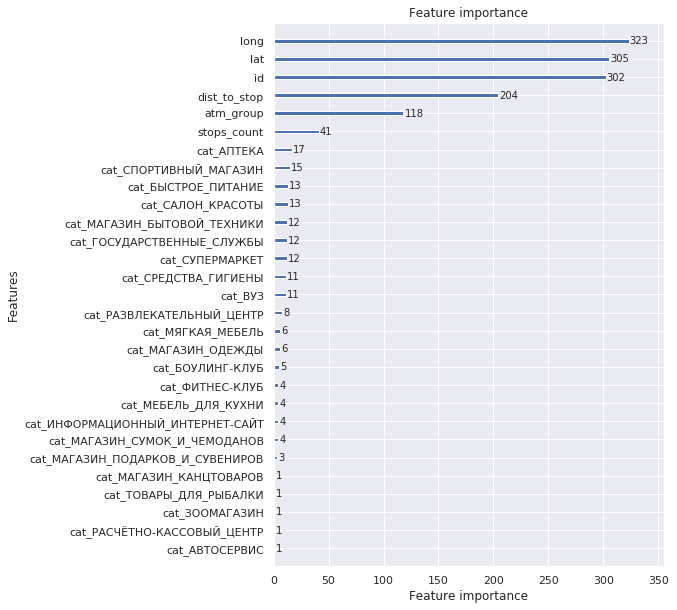

In [95]:
%matplotlib inline
lgb.plot_importance(gbm, max_num_features=40, figsize=(7,10))

In [96]:
rmse(Y_valid, gbm.predict(X_valid))

0.045971638126885817

In [412]:
param_grid = {'max_depth': [15, 20, 25],
              'n_estimators': [200, 250, 300],
#               'boosting_type':['gbdt', 'dart', 'goss']
#               'reg_alpha':[0, .4 ], # L1 regularization term on weights.
#               'reg_lambda':[0, .4 ] # L2 regularization term on weights.
             }

grid_gbm = model_selection.GridSearchCV(gbm,
                            param_grid=param_grid, 
                            cv=5, scoring=rmse_score, verbose=1, n_jobs=-1)
grid_gbm.fit(X_, Y_, eval_metric='rmse', verbose=False)
rmse(Y_valid, grid_gbm.best_estimator_.predict(X_valid))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   18.0s finished


0.0286995542835094

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=25, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0) 0.0286995542835094


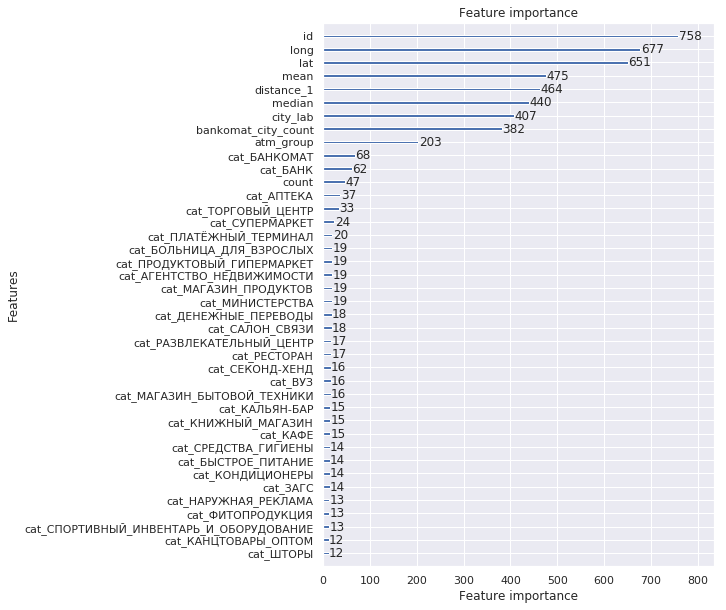

In [413]:
print(grid_gbm.best_estimator_, rmse(Y_valid, grid_gbm.best_estimator_.predict(X_valid)))
# lgb.plot_importance(grid_gbm.best_estimator_)
lgb.plot_importance(grid_gbm.best_estimator_, max_num_features=40, figsize=(7,10))

###  Выбираю самые полезные признаки

In [266]:
X_feat = X[X.columns[[np.argsort(-grid_gbm.best_estimator_.feature_importances_)[:500]]]].copy()

In [267]:
drop_cols = ['target', 'isTrain', 'address', 'address_rus', 
#              'address_translit',
             'inplace_cats', 'city',
             'count_latlong']

X_ = X_feat[X_feat.isTrain].drop(drop_cols, axis=1)
Y_ = X_feat.loc[X_feat.isTrain, 'target']

X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.2, random_state=1)

In [284]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5008 entries, 2161 to 5157
Columns: 493 entries, cat_СЛУЖБА СПАСЕНИЯ to cat_НЕРУДНЫЕ МАТЕРИАЛЫ
dtypes: float64(493)
memory usage: 18.9 MB


## Отправка сабмита

Отправка данных на данных с парсингом:

In [24]:
X_test = X[~X.isTrain].drop(drop_cols, axis=1)
submit = pd.DataFrame(grid_gbm.best_estimator_.predict(X_test), index=test.index,columns=['target'])
submit.to_csv('submit.csv')